# Minería de Datos sobre Capa Oro

Este notebook desarrolla un análisis completo de **minería de datos** sobre información meteorológica de la provincia de Misiones.

### Objetivos
1. **Generar y explorar la variable `LLUEVE`** para identificar días lluviosos.
2. **Descubrir patrones y relaciones ocultas** mediante visualización, combinaciones y clustering.
3. **Cubrir las etapas de minería de datos** dentro del flujo **CRISP-DM**:
   - Comprensión de los datos
   - Preparación
   - Minería / Modelado
   - Evaluación

El enfoque es **no supervisado**, buscando patrones sin usar etiquetas predefinidas.

# Importar las librerías necesarias

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from mlxtend.frequent_patterns import apriori, association_rules
import warnings

# Deshabilitar warnings futuros
warnings.simplefilter(action='ignore', category=FutureWarning)

MINERIA_DIR = Path('../data/mineria')
MINERIA_DIR.mkdir(parents=True, exist_ok=True)

print("Importación de librerías completada.")

Importación de librerías completada.


## Carga de datos

Se cargan los datasets generados en la **Capa Oro**:
- `dataset_oro_diario.csv` → Datos diarios por estación.
- `dataset_oro_horario.csv` → Datos horarios por estación.

In [2]:
# Carga de datasets Oro
file_diario = '../data/oro/dataset_oro_diario.csv'
file_horario = '../data/oro/dataset_oro_horario.csv'

df_diario = pd.read_csv(file_diario)
df_horario = pd.read_csv(file_horario)

print("Dimensiones datos diarios:", df_diario.shape)
print("Dimensiones datos horarios:", df_horario.shape)

df_diario.head()

Dimensiones datos diarios: (1185, 25)
Dimensiones datos horarios: (20145, 10)


,ESTACION,FECHA,TEMP_MEAN,TEMP_MIN,TEMP_MAX,PNM_MEAN,PNM_MIN,PNM_MAX,HUM_MEAN,HUM_MIN,...,WIND_SPEED_MIN,WIND_SPEED_MAX,TEMP_MEAN_NORM,PNM_MEAN_NORM,HUM_MEAN_NORM,WIND_DIR_MEAN_NORM,WIND_SPEED_MEAN_NORM,AMP_TERMICA,RANGO_PRESION,RANGO_HUMEDAD
0,IGUAZU AERO,2024-06-01,16.3,10,23,1019.3,1018,1022,82.4,62,...,4,17,0.40580,0.59930,0.70882,0.10651,0.25641,13,4,33
1,IGUAZU AERO,2024-06-02,19.7,14,29,1017.1,1015,1019,77.6,51,...,4,15,0.52899,0.52265,0.62895,0.08802,0.23443,15,4,40
2,IGUAZU AERO,2024-06-03,20.2,16,26,1019.3,1018,1021,82.7,62,...,4,17,0.54710,0.59930,0.71381,0.27391,0.21978,10,3,36
3,IGUAZU AERO,2024-06-04,20.1,15,27,1018.5,1016,1020,83.6,61,...,0,11,0.54348,0.57143,0.72879,0.31913,0.16117,12,4,38
4,IGUAZU AERO,2024-06-05,21.5,18,27,1018.2,1016,1021,80.0,56,...,4,13,0.59420,0.56098,0.66889,0.09144,0.22711,9,5,38


## Generación de la variable `LLUEVE`

Como no contamos con precipitación directa, se define la lluvia mediante la regla heurística:

- **1 (Llueve)** si `Humedad > 75%` y `Presión < 1010 hPa`  
- **0 (No llueve)** en caso contrario

Esto permite contar con una etiqueta binaria para minería de datos.

In [4]:
# Crear variables binarias de lluvia

# Condición: humedad > 75% y presión < 1010 hPa
humedad = 75
presion = 1010

df_diario['LLUEVE'] = ((df_diario['HUM_MEAN'] > humedad) & 
                       (df_diario['PNM_MEAN'] < presion)).astype(int)

df_horario['LLUEVE'] = ((df_horario['HUM'] > humedad) & 
                        (df_horario['PNM'] < presion)).astype(int)

print("Variables generadas")
print("")
print("Distribución LLUEVE (0=No,1=Sí):")
print("")
print(df_diario['LLUEVE'].value_counts())

df_diario[['ESTACION','FECHA','HUM_MEAN','PNM_MEAN','LLUEVE']].head(10)

Variables generadas

Distribución LLUEVE (0=No,1=Sí):

LLUEVE
0    1086
1      99
Name: count, dtype: int64


,ESTACION,FECHA,HUM_MEAN,PNM_MEAN,LLUEVE
0,IGUAZU AERO,2024-06-01,82.4,1019.3,0
1,IGUAZU AERO,2024-06-02,77.6,1017.1,0
2,IGUAZU AERO,2024-06-03,82.7,1019.3,0
3,IGUAZU AERO,2024-06-04,83.6,1018.5,0
4,IGUAZU AERO,2024-06-05,80.0,1018.2,0
5,IGUAZU AERO,2024-06-06,81.0,1018.0,0
6,IGUAZU AERO,2024-06-07,80.2,1018.8,0
7,IGUAZU AERO,2024-06-08,77.3,1017.1,0
8,IGUAZU AERO,2024-06-09,76.8,1012.6,0
9,IGUAZU AERO,2024-06-10,73.8,1013.6,0


# Guardar el dataset con las variables generadas

In [5]:
# Guardar los datasets con la nueva variable. Exportación a CSV
df_diario.to_csv(MINERIA_DIR / 'dataset_mineria_diario.csv', index=False)
df_horario.to_csv(MINERIA_DIR / 'dataset_mineria_horario.csv', index=False)

print("Archivos generados con la variable LLUEVE.")
print(f"Filas diarias: {len(df_diario)} | Filas horarias: {len(df_horario)}")
print("Muestra de datos con la variable LLUEVE (diario):")
print(df_diario[['ESTACION','FECHA','HUM_MEAN','PNM_MEAN','LLUEVE']].head())

Archivos generados con la variable LLUEVE.
Filas diarias: 1185 | Filas horarias: 20145
Muestra de datos con la variable LLUEVE (diario):
      ESTACION       FECHA  HUM_MEAN  PNM_MEAN  LLUEVE
0  IGUAZU AERO  2024-06-01      82.4    1019.3       0
1  IGUAZU AERO  2024-06-02      77.6    1017.1       0
2  IGUAZU AERO  2024-06-03      82.7    1019.3       0
3  IGUAZU AERO  2024-06-04      83.6    1018.5       0
4  IGUAZU AERO  2024-06-05      80.0    1018.2       0


## Exploración y visualización de la variable `LLUEVE`

Se analiza la distribución de días con lluvia, por estación y de manera temporal.
Además, se incluye un **heatmap de correlación** para detectar **relaciones ocultas** entre variables.

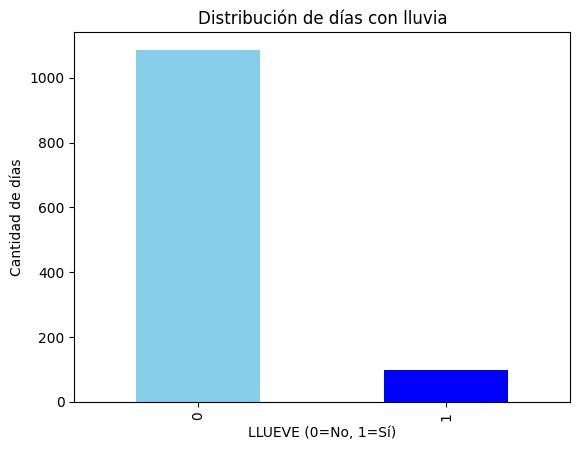

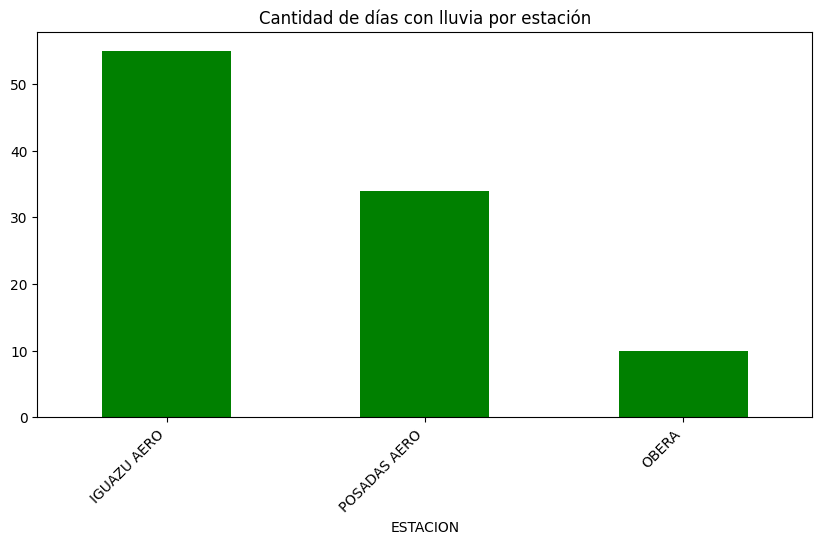

In [6]:
# Conteo lluvia
df_diario['LLUEVE'].value_counts().plot(kind='bar', color=['skyblue','blue'])
plt.title("Distribución de días con lluvia")
plt.xlabel("LLUEVE (0=No, 1=Sí)")
plt.ylabel("Cantidad de días")
plt.show()

# Lluvia por estación
df_diario.groupby('ESTACION')['LLUEVE'].sum().sort_values(ascending=False).plot(kind='bar', figsize=(10,5), color='green')
plt.title("Cantidad de días con lluvia por estación")
plt.xticks(rotation=45, ha='right')
plt.show()

### Heatmap de correlación general

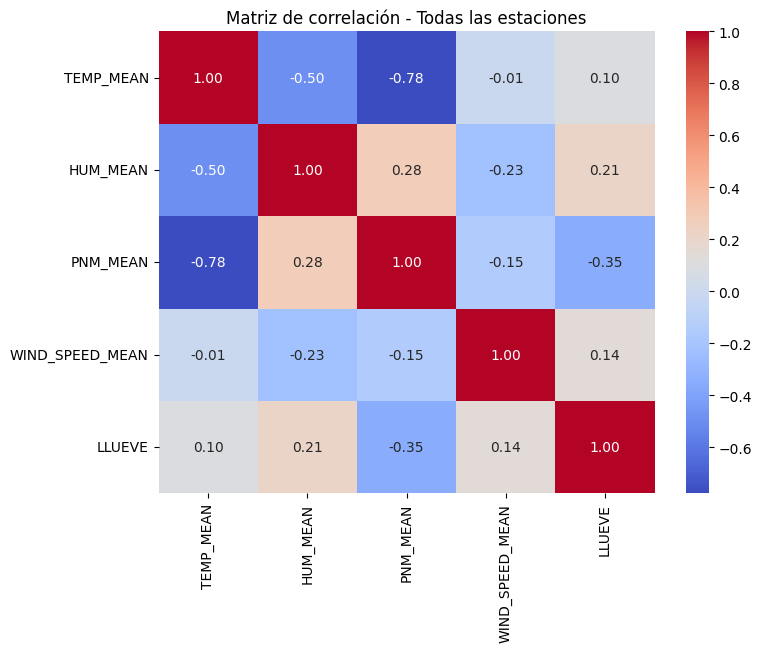

In [7]:

vars_corr = ['TEMP_MEAN','HUM_MEAN','PNM_MEAN','WIND_SPEED_MEAN','LLUEVE']

plt.figure(figsize=(8,6))
sns.heatmap(df_diario[vars_corr].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de correlación - Todas las estaciones")
plt.show()



### Generar un heatmap por cada estación

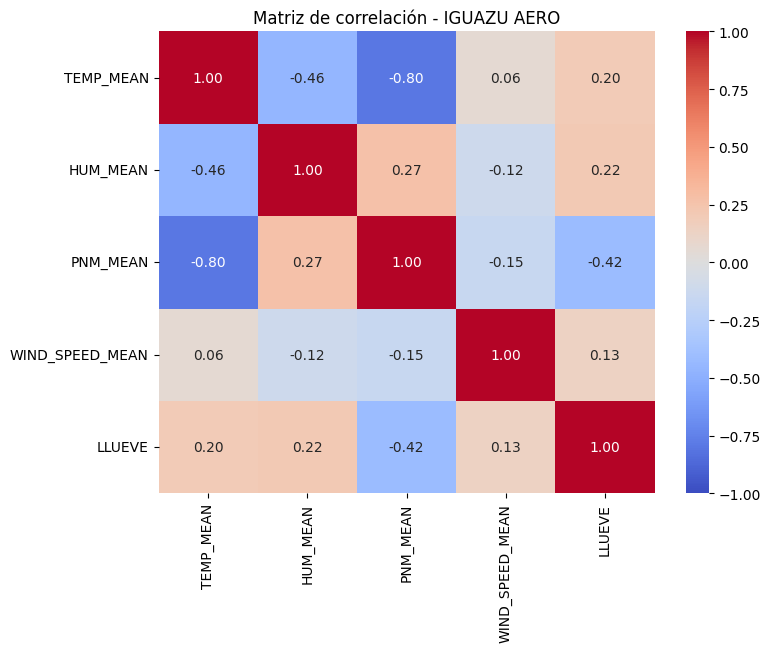

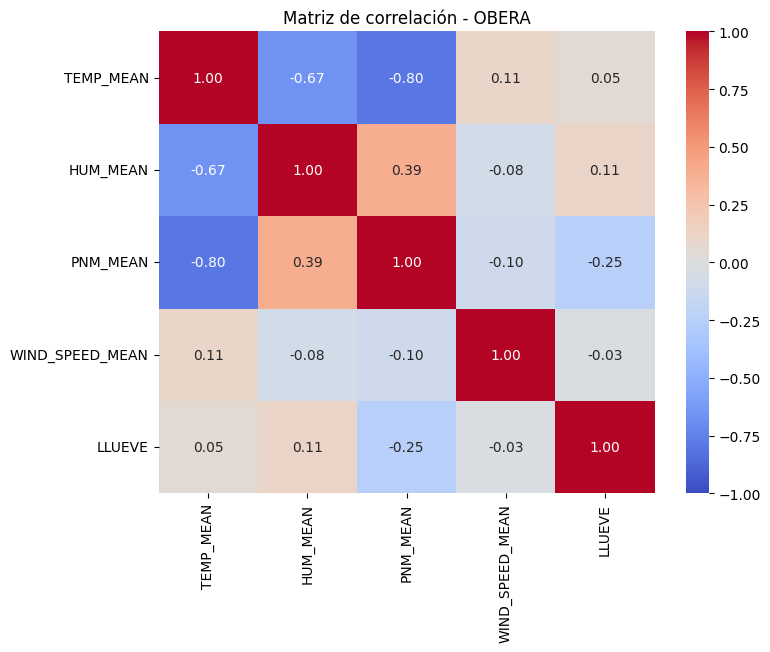

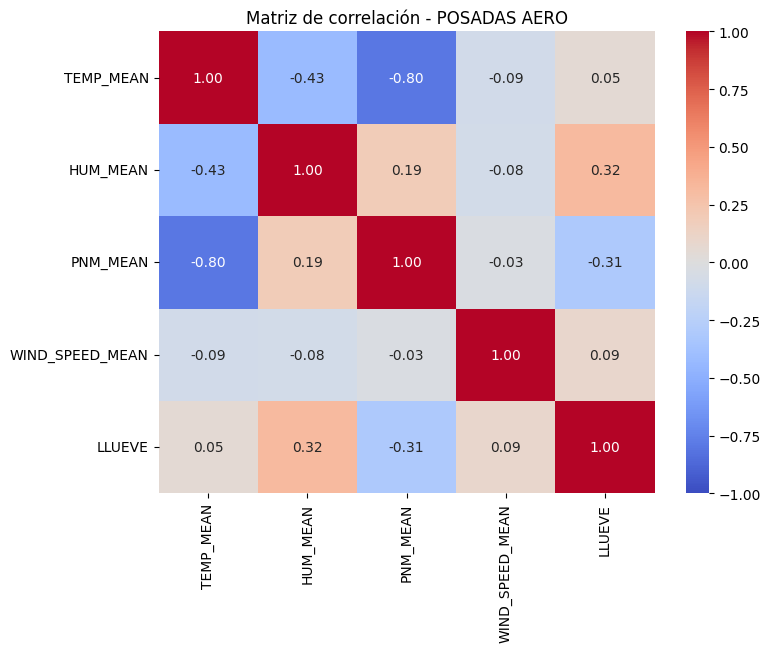

In [8]:
for estacion in df_diario['ESTACION'].unique():
    df_est = df_diario[df_diario['ESTACION'] == estacion]
    
    plt.figure(figsize=(8,6))
    sns.heatmap(df_est[vars_corr].corr(), annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
    plt.title(f"Matriz de correlación - {estacion}")
    plt.show()


## Combinaciones de condiciones climáticas

Debido a que la lluvia es muy poco frecuente, **Apriori** no genera reglas útiles.
Se opta por un análisis de **combinaciones discretizadas** para estimar la probabilidad de lluvia por tipo de día.

1. **Discretización**:
   - `TEMP_MEAN` → Frío / Cálido
   - `HUM_MEAN` → Baja / Alta
   - `PNM_MEAN` → Baja / Alta
2. **Agrupación** por combinación y cálculo de:
   - Días totales
   - Días con lluvia
   - Porcentaje de lluvia


In [9]:
# Discretización en 2 categorías
df_assoc = df_diario[['TEMP_MEAN','HUM_MEAN','PNM_MEAN','LLUEVE']].copy()
df_assoc['TEMP_CAT'] = pd.cut(df_assoc['TEMP_MEAN'], bins=[-5,20,50], labels=['Frio','Calido'])
df_assoc['HUM_CAT'] = pd.cut(df_assoc['HUM_MEAN'], bins=[0,85,100], labels=['Baja','Alta'])
df_assoc['PNM_CAT'] = pd.cut(df_assoc['PNM_MEAN'], bins=[950,1010,1050], labels=['Baja','Alta'])

# Agrupación
df_grouped = df_assoc.groupby(['TEMP_CAT','HUM_CAT','PNM_CAT']).agg(
    dias_total=('LLUEVE','count'),
    dias_lluvia=('LLUEVE','sum')
).reset_index()

df_grouped['porcentaje_lluvia'] = (df_grouped['dias_lluvia'] / df_grouped['dias_total'] * 100).round(2)

df_grouped.sort_values('porcentaje_lluvia', ascending=False)

,TEMP_CAT,HUM_CAT,PNM_CAT,dias_total,dias_lluvia,porcentaje_lluvia
2,Frio,Alta,Baja,8,8,100.00
6,Calido,Alta,Baja,35,35,100.00
0,Frio,Baja,Baja,2,1,50.00
4,Calido,Baja,Baja,215,55,25.58
3,Frio,Alta,Alta,167,0,0.00
1,Frio,Baja,Alta,178,0,0.00
5,Calido,Baja,Alta,497,0,0.00
7,Calido,Alta,Alta,83,0,0.00


## Clustering de días meteorológicos

Se aplica **K-Means** para agrupar días según sus condiciones meteorológicas:

- Variables: `TEMP_MEAN`, `HUM_MEAN`, `PNM_MEAN`, `WIND_SPEED_MEAN`
- Escalado previo para que todas tengan igual peso
- **PCA** para visualizar los clusters en 2D

Cada color representa un **tipo de día**:
- Cálido-Seco
- Frío-Húmedo
- Intermedio

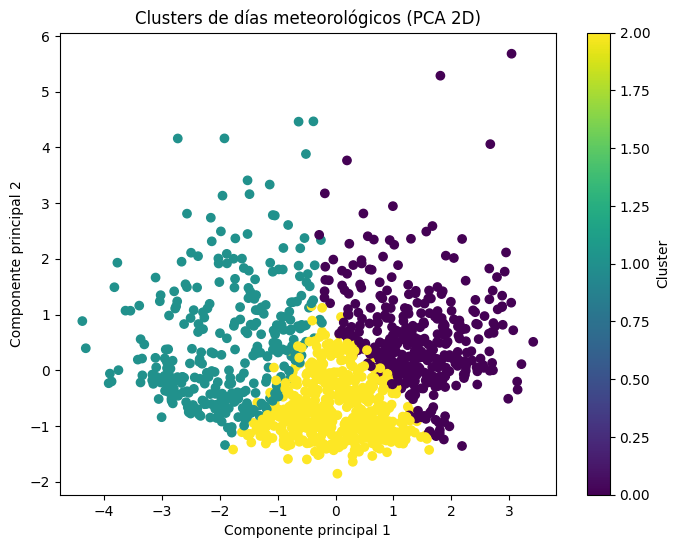

Contribución de cada variable a los componentes principales:


,PC1,PC2
TEMP_MEAN,0.631691,-0.281946
HUM_MEAN,-0.472085,-0.283766
PNM_MEAN,-0.589889,0.189071
WIND_SPEED_MEAN,0.173588,0.896792


CLUSTER
0    0.105691
1    0.000000
2    0.117647
Name: LLUEVE, dtype: float64

In [10]:
# Variables numéricas
X_clust = df_diario[['TEMP_MEAN','HUM_MEAN','PNM_MEAN','WIND_SPEED_MEAN']]

# Escalado
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clust)

# K-Means
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df_diario['CLUSTER'] = kmeans.fit_predict(X_scaled)

# PCA para visualización
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=df_diario['CLUSTER'], cmap='viridis')
plt.title("Clusters de días meteorológicos (PCA 2D)")
plt.xlabel("Componente principal 1")
plt.ylabel("Componente principal 2")
plt.colorbar(label='Cluster')
plt.show()

# 🔹 Interpretación de componentes principales
pca_df = pd.DataFrame(pca.components_, columns=X_clust.columns, index=['PC1','PC2'])
print("Contribución de cada variable a los componentes principales:")
display(pca_df.T)

# Probabilidad de lluvia por cluster
df_diario.groupby('CLUSTER')['LLUEVE'].mean()

### Interpretación del PCA con Clustering

En el gráfico PCA 2D:

- **Eje X (Componente Principal 1)**: 
  - Gradiente entre **días cálidos y secos** (derecha) y **días fríos y húmedos** (izquierda).  
- **Eje Y (Componente Principal 2)**: 
  - Intensidad del **viento medio diario**.  
  - Arriba → días ventosos | Abajo → días calmos.

- **Colores de los puntos**: 
  - Cada color representa un **cluster identificado por K-Means**:  
    1. **Cluster 0 (amarillo/verde)** → días cálidos y secos  
    2. **Cluster 1 (violeta/azul)** → días fríos y húmedos  
    3. **Cluster 2 (verde/azulado)** → días intermedios

> Esta visualización permite entender **tipos de días** y su relación con la lluvia.


## Visualización con t-SNE

El **t-SNE (t-Distributed Stochastic Neighbor Embedding)** es una técnica de **reducción de dimensionalidad no lineal** utilizada principalmente para **visualización**.

- **Objetivo:** Representar datos de alta dimensión en 2D/3D preservando **vecindades locales**.
- **Ventaja:** Permite descubrir patrones o agrupamientos que **PCA lineal** podría no reflejar.
- **Limitación:** 
  - Los ejes no tienen interpretación física como PCA. 
  - Solo importa la **proximidad de puntos**: puntos cercanos → días meteorológicos similares.

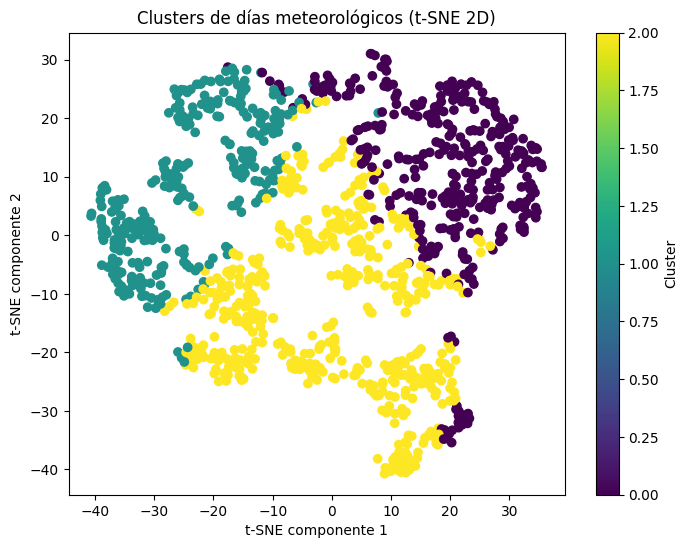

In [11]:
# t-SNE en 2D
tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
X_tsne = tsne.fit_transform(X_scaled)

# Visualización de clusters en t-SNE
plt.figure(figsize=(8,6))
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=df_diario['CLUSTER'], cmap='viridis')
plt.title("Clusters de días meteorológicos (t-SNE 2D)")
plt.xlabel("t-SNE componente 1")
plt.ylabel("t-SNE componente 2")
plt.colorbar(label='Cluster')
plt.show()

### Interpretación del gráfico t-SNE

- Cada **punto** = un **día meteorológico**.
- **Colores** = clusters asignados por K-Means (tipos de días).  
- **Proximidad** = similitud de condiciones:  
  - Puntos cercanos → días con condiciones similares  
  - Puntos alejados → días con comportamientos distintos  
- **Los ejes no representan variables meteorológicas directas**, solo una proyección que facilita la visualización de grupos.

# Conclusión

En esta etapa se trabajó sobre los datos horarios procesados del SMN, aplicando técnicas de **minería de datos y análisis exploratorio** para descubrir patrones relacionados con la ocurrencia de lluvia.  
El objetivo principal fue **generar conocimiento a partir de los datos procesados**, preparando la información para etapas posteriores de clasificación y modelado predictivo.

1. **Generación de `LLUEVE`:**  
   - Se creó una etiqueta binaria que indica lluvia (1) o no lluvia (0), derivada de las condiciones meteorológicas.  
   - Se confirmó un **dataset desbalanceado**, con pocas ocurrencias de la clase positiva.

2. **Exploración y relaciones ocultas:**  
   - Los **heatmaps de correlación** mostraron que la lluvia está fuertemente asociada a **humedad alta** y **presión baja**.  
   - Al analizar por estación meteorológica, se observaron **patrones consistentes**.

3. **Combinaciones de condiciones:**  
   - Los días con **humedad alta y presión baja** alcanzan **máxima probabilidad de lluvia** en el histórico.  
   - Los **días cálidos y húmedos** son los más propensos a eventos de lluvia.

4. **Clustering y reducción de dimensionalidad:**  
   - El algoritmo **K-Means** identificó **3 tipos de días**: cálidos-secos, fríos-húmedos e intermedios.  
   - La **PCA 2D** permitió interpretar los ejes principales como:  
     - **PC1** → Gradiente cálido vs. frío-húmedo  
     - **PC2** → Intensidad del viento  
   - La técnica **t-SNE** confirmó la **separación de clusters** y reveló vecindades locales entre días con características similares.

Este análisis de **minería de datos** permitió comprender la estructura y los patrones del dataset, dejando la información **lista para la siguiente etapa de clasificación supervisada**, donde se evaluará la capacidad predictiva de distintos modelos sobre la variable `LLUEVE`.